# Homework and bake-off: pragmatic color descriptions

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2021"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [All two-word examples as a dev corpus](#All-two-word-examples-as-a-dev-corpus)
1. [Dev dataset](#Dev-dataset)
1. [Random train–test split for development](#Random-train–test-split-for-development)
1. [Question 1: Improve the tokenizer [1 point]](#Question-1:-Improve-the-tokenizer-[1-point])
1. [Use the tokenizer](#Use-the-tokenizer)
1. [Question 2: Improve the color representations [1 point]](#Question-2:-Improve-the-color-representations-[1-point])
1. [Use the color representer](#Use-the-color-representer)
1. [Initial model](#Initial-model)
1. [Question 3: GloVe embeddings [1 point]](#Question-3:-GloVe-embeddings-[1-point])
1. [Try the GloVe representations](#Try-the-GloVe-representations)
1. [Question 4: Color context [3 points]](#Question-4:-Color-context-[3-points])
1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bakeoff [1 point]](#Bakeoff-[1-point])

## Overview

This homework and associated bake-off are oriented toward building an effective system for generating color descriptions that are pragmatic in the sense that they would help a reader/listener figure out which color was being referred to in a shared context consisting of a target color (whose identity is known only to the describer/speaker) and a set of distractors.

The notebook [colors_overview.ipynb](colors_overview.ipynb) should be studied before work on this homework begins. That notebook provides backgroud on the task, the dataset, and the modeling code that you will be using and adapting.

The homework questions are more open-ended than previous ones have been. Rather than asking you to implement pre-defined functionality, they ask you to try to improve baseline components of the full system in ways that you find to be effective. As usual, this culminates in a prompt asking you to develop a novel system for entry into the bake-off. In this case, though, the work you do for the homework will likely be directly incorporated into that system (not required, but an efficient way to work at the very least).

## Set-up

See [colors_overview.ipynb](colors_overview.ipynb) for set-up in instructions and other background details.

In [2]:
from colors import ColorsCorpusReader
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_color_describer import ContextualColorDescriber
from torch_color_describer import create_example_dataset

import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL

In [3]:
utils.fix_random_seeds()

In [4]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv")

## All two-word examples as a dev corpus

So that you don't have to sit through excessively long training runs during development, I suggest working with the two-word-only subset of the corpus until you enter into the late stages of system testing.

In [5]:
dev_corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    word_count=2,
    normalize_colors=True)

In [6]:
dev_examples = list(dev_corpus.read())

This subset has about one-third the examples of the full corpus:

In [7]:
len(dev_examples)

13890

We __should__ worry that it's not a fully representative sample. Most of the descriptions in the full corpus are shorter, and a large proportion are longer. So this dataset is mainly for debugging, development, and general hill-climbing. All findings should be validated on the full dataset at some point.

## Dev dataset

The first step is to extract the raw color and raw texts from the corpus:

In [8]:
dev_rawcols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])

The raw color representations are suitable inputs to a model, but the texts are just strings, so they can't really be processed as-is. Question 1 asks you to do some tokenizing!

## Random train–test split for development

For the sake of development runs, we create a random train–test split:

In [9]:
dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test = \
    train_test_split(dev_rawcols, dev_texts)

## Question 1: Improve the tokenizer [1 point]

This is the first required question – the first required modification to the default pipeline.

The function `tokenize_example` simply splits its string on whitespace and adds the required start and end symbols:

In [10]:
from nltk.parse import CoreNLPParser

In [11]:
"""
Summary of tokenizer strategy:
- produce tokens that are similar to those used by GloVe, in order to increase
alignment between word representations and tokens. Hence, we import and use
the Stanford Tokenizer, which was used in the GloVe paper for creating embeddings.
- as in Monroe 2017 paper, remove the er/est/ish endings. It might be useful to 
process adjectives (ex `dark`) separately from their suffixes, so that the model can
better learn the <i>meanings</i> of the adjectives separately from how to represent the
<i>strength</i> of the adjective.
- from visually examining the word descriptions, it seems like relatively simple words
are used, so we did not think it was necessary to use tokenization schemes that made 
better use of subword representations than the GloVe method.
"""
# split off endings: copied from https://github.com/futurulus/colors-in-context/blob/master/tokenizers.py
ENDINGS = ['er', 'est', 'ish']

def heuristic_segmenter(word):
    for ending in ENDINGS:
        if word.endswith(ending):
            return [word[:-len(ending)], ending]
    return [word]

def tokenize_example(s):
    # normalize: transform entire string to lower case
    s = s.lower()
    
    # use stanford tokenizer, which is used for GloVe 
    # https://github.com/nltk/nltk/wiki/Stanford-CoreNLP-API-in-NLTK
    # glove paper: https://www.aclweb.org/anthology/D14-1162.pdf
    parser = CoreNLPParser(url='http://localhost:9000')
    words = list(parser.tokenize(s))
    
    return [START_SYMBOL] + [seg for w in words for seg in heuristic_segmenter(w)] + [END_SYMBOL]

# An alternative tokenization method explored earlier.
#     import string
#     import re
    
#     # normalize: transform entire string to lower case
#     s = s.lower()
    
#     # remove all punctuation since these could be irrelevant
#     # to the description of the color
#     # first, transform ### into XXX so that it's not stripped
#     s = re.sub('###', 'XXX', s)
#     table = str.maketrans(dict.fromkeys(string.punctuation))
#     s = s.translate(table) 

#     return [START_SYMBOL] + s.split() + [END_SYMBOL]

In [12]:
print(tokenize_example(dev_texts_train[376]))
print(tokenize_example("Hi ### Bye can't wait!!"))
print(tokenize_example("Darker blue, darkest."))

['<s>', 'aqua', ',', 'teal', '</s>']
['<s>', 'hi', '###', 'bye', 'ca', "n't", 'wait', '!!', '</s>']
['<s>', 'dark', 'er', 'blue', ',', 'dark', 'est', '.', '</s>']


__Your task__: Modify `tokenize_example` so that it does something more sophisticated with the input text. 

__Notes__:

* There are useful ideas for this in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142)
* There is no requirement that you do word-level tokenization. Sub-word and multi-word are options.
* This question can interact with the size of your vocabulary (see just below), and in turn with decisions about how to use `UNK_SYMBOL`.

__Important__: don't forget to add the start and end symbols, else the resulting models will definitely be terrible! The following test will check that your tokenizer has this property:

In [13]:
def test_tokenize_example(func):
    s = "A test string"
    result = func(s)
    assert all(isinstance(tok, str) for tok in result), \
        "The tokenizer must return a list of strings."
    assert result[0] == START_SYMBOL, \
        "The tokenizer must add START_SYMBOL as the first token."
    assert result[-1] == END_SYMBOL, \
        "The tokenizer must add END_SYMBOL as the final token."
    print("test passed!")

In [14]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_tokenize_example(tokenize_example)

test passed!


## Use the tokenizer

Once the tokenizer is working, run the following cell to tokenize your inputs:

In [15]:
dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]

dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]

We use only the train set to derive a vocabulary for the model:

In [16]:
dev_vocab = sorted({w for toks in dev_seqs_train for w in toks})

dev_vocab += [UNK_SYMBOL]

It's important that the `UNK_SYMBOL` is included somewhere in this list. In test examples, words not seen in training will be mapped to `UNK_SYMBOL`. 

Conceptual note: If you model's vocab is the same as your train vocab, then `UNK_SYMBOL` will never be encountered during training, so it will be a random vector at test time.

In [17]:
len(dev_vocab)

917

## Question 2: Improve the color representations [1 point]

This is the second required pipeline improvement for the assignment. 

The following functions do nothing at all to the raw input colors we get from the corpus. 

In [18]:
"""
Summary of color representation:
- fourier transform as motivated in Monroe paper
"""
from itertools import product

def represent_color_context(colors):
    return [represent_color(color) for color in colors]

def represent_color(color):
    
    # translate HLS format into HSV format
    H = color[0]
    L = color[1]
    S = color[2]
    
    h = H
    v = L + 1.0 * S * min(L, 1-L)
    s = 0
    if v != 0:
        s = 2.0 * (1 - 1.0 * L/v)
        
    # fourier transform
    # h,s,v are already all normalized to be in [0,1] range 
    # due to colors.py
    f_hat_real = []
    f_hat_imag = []
    for j, k, l in product((0, 1, 2), repeat=3):
        f_jkl = np.exp(-2j * np.pi * (j*h + k*s + l*v))
        f_hat_real.append(f_jkl.real)
        f_hat_imag.append(f_jkl.imag)
        
    return f_hat_real + f_hat_imag

In [19]:
print(len(represent_color_context(dev_rawcols_train[0])[0]))
print(len(represent_color_context(dev_rawcols_train[0])))

54
3


__Your task__: Modify `represent_color_context` and/or `represent_color` to represent colors in a new way.
    
__Notes__:

* You are not required to keep `represent_color`. This might be unnatural if you want to perform an operation on each color trio all at once.
* For that matter, if you want to process all of the color contexts in the entire data set all at once, that is fine too, as long as you can also perform the operation at test time with an unknown number of examples being tested.

* The Fourier-transform method of [Monroe et al. 2016](https://www.aclweb.org/anthology/D16-1243/) and [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142) is a proven choice for our task. __It is not required that you implement this.__ However, if you decide to, you might find that the overly terse presentation in the paper is an obstacle. They key thing to see is that the notation $\hat{f}_{jkl}$ is meant to specify a full coordinate system. Thus, you might do something like

  ```
from itertools import product
for j, k, l in product((0, 1, 2), repeat=3):    
    f_jkl = ...
```

  and collect these `f_jkl` values in a list of 27 values. Additionally, in Python, [`2j` produces a value with `real` and `imag` attributes](https://docs.python.org/3.7/library/cmath.html). Each element `f_jkl` should have these components. If you concatenate the `real` and `imag` parts of all the `f_jkl`, you will have a 54-dimensional representation, as in the paper. Remember to start with an HSV representation, and with $h$ in $[0, 360]$, $s$ in $[0, 200]$, and $v$ in $[0, 200]$ (or else do the scaling differently). Note that the values in our corpus are in HLS format, [which are easily converted to HSV](https://en.wikipedia.org/wiki/HSL_and_HSV#HSV_to_HSL).

The following test seeks to ensure only that the output of your `represent_color_context` will be compatible with the models we are creating:

In [20]:
def test_represent_color_context(func):
    """`func` should be `represent_color_context`"""
    example = [
        [0.786, 0.58, 0.87],
        [0.689, 0.44, 0.92],
        [0.628, 0.32, 0.81]]
    result = func(example)
    assert len(result) == len(example), \
        ("Color context representations need to represent each color "
         "separately. (We assume the final color is the target.)")
    for i, color in enumerate(result):
        assert all(isinstance(x, float) for x in color), \
            ("All color representations should be lists of floats. "
             "Color {} is {}".format(i, color))
    print("test passed!")

In [21]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_represent_color_context(represent_color_context)

test passed!


## Use the color representer

The following cell just runs your `represent_color_context` on the train and test sets:

In [22]:
dev_cols_train = [represent_color_context(colors) for colors in dev_rawcols_train]

dev_cols_test = [represent_color_context(colors) for colors in dev_rawcols_test]

At this point, our preprocessing steps are complete, and we can fit a first model.

## Initial model

The first model is configured right now to be a small model run for just a few iterations. It should be enough to get traction, but it's unlikely to be a great model. You are free to modify this configuration if you wish; it is here just for demonstration and testing:

In [23]:
dev_mod = ContextualColorDescriber(
    dev_vocab,
    early_stopping=True)

In [220]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    %time _ = dev_mod.fit(dev_cols_train, dev_seqs_train)
else:
    dev_mod.fit(dev_cols_train, dev_seqs_train)

/Users/kathyzfan/cs224u-kf/torch_color_describer.py:679: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Stopping after epoch 105. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 33.52999663352966

CPU times: user 16min 48s, sys: 2min 55s, total: 19min 43s
Wall time: 20min 35s


The canonical bake-off evaluation function is `evaluate`. Our primary metric is `listener_accuracy`; the BLEU score is included as a check to ensure that your system is speaking English!

In [221]:
evaluation = dev_mod.evaluate(dev_cols_test, dev_seqs_test)

In [222]:
evaluation.keys()

dict_keys(['listener_accuracy', 'corpus_bleu', 'target_index', 'predicted_index', 'predicted_utterance'])

In [223]:
# with previous tokenizer: 0.7895191477109128
evaluation['listener_accuracy']

0.7898070832133602

In [224]:
dev_mod.listener_accuracy(dev_cols_test, dev_seqs_test)

0.7898070832133602

In [225]:
# with previous tokenizer: 0.6862670442151716
evaluation['corpus_bleu']

0.6748469145139276

In [226]:
bleu, predicted_utterances = dev_mod.corpus_bleu(dev_cols_test, dev_seqs_test)

bleu

0.6748469145139276

In [227]:
evaluation['target_index'][: 5]

[2, 2, 2, 2, 2]

In [228]:
evaluation['predicted_index'][: 5]

[2, 2, 2, 0, 2]

In [229]:
evaluation['predicted_utterance'][: 5]

[['<s>', 'bright', 'est', 'purple', '</s>'],
 ['<s>', 'yellow', 'ish', 'green', '</s>'],
 ['<s>', 'dull', 'purple', '</s>'],
 ['<s>', 'bright', 'pink', '</s>'],
 ['<s>', 'bright', 'green', '</s>']]

We can also see the model's predicted sequences given color context inputs:

In [230]:
dev_mod.predict(dev_cols_test[: 1])

[['<s>', 'bright', 'est', 'purple', '</s>']]

In [231]:
dev_seqs_test[: 5]

[['<s>', 'right', 'side', '###', 'purple', 'pink', 'ish', '</s>'],
 ['<s>', 'dark', 'er', 'yellow', '</s>'],
 ['<s>', 'dull', 'one', '</s>'],
 ['<s>', 'light', 'pink', '</s>'],
 ['<s>', 'like', 'mint', '</s>']]

Medium pink
Mint green.
Mud brown
Mud brown
Camo green


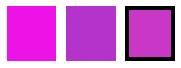

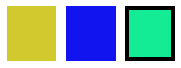

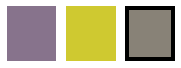

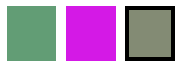

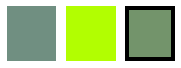

In [232]:
# Note: these don't match with the dev order above
# since we created random train/dev/test splits
for i in range(5):
    dev_examples[i].display()

## Question 3: GloVe embeddings [1 point]

The above model uses a random initial embedding, as configured by the decoder used by `ContextualColorDescriber`. This homework question asks you to consider using GloVe inputs. 

__Your task__: Complete `create_glove_embedding` so that it creates a GloVe embedding based on your model vocabulary. This isn't mean to be analytically challenging, but rather just to create a basis for you to try out other kinds of rich initialization.

In [24]:
GLOVE_HOME = os.path.join('data', 'glove.6B')

In [25]:
def create_glove_embedding(vocab, glove_base_filename='glove.6B.50d.txt'):
    # Use `utils.glove2dict` to read in the GloVe file:
    glove_dict = utils.glove2dict(
        os.path.join(GLOVE_HOME, glove_base_filename))

    # Use `utils.create_pretrained_embedding` to create the embedding.
    # This function will, by default, ensure that START_TOKEN,
    # END_TOKEN, and UNK_TOKEN are included in the embedding.
    # returns: embedding, expanded_vocab
    return utils.create_pretrained_embedding(glove_dict, vocab)

In [26]:
def test_create_glove_embedding(func):
    vocab = ['NLU', 'is', 'the', 'future', '.', '$UNK', '<s>', '</s>']
    glove_embedding, glove_vocab = func(vocab, 'glove.6B.50d.txt')
    assert isinstance(glove_embedding, np.ndarray), \
        "Expected embedding type {}; got {}".format(
        glove_embedding.__class__.__name__, glove_embedding.__class__.__name__)
    assert glove_embedding.shape == (8, 50), \
        "Expected embedding shape (8, 50); got {}".format(glove_embedding.shape)
    assert glove_vocab == vocab, \
        "Expected vocab {}; got {}".format(vocab, glove_vocab)
    print("test passed!")

In [27]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_create_glove_embedding(create_glove_embedding)

test passed!


## Try the GloVe representations

The extent to which GloVe is useful will depend heavily on how aligned your tokenization scheme is with the GloVe vocabulary. For example, if you did character-level tokenization, then the GloVe embedding space is not well-aligned with your tokenizer and using GloVe should have little no positive effect.

Let's see if GloVe helped for our development data:

In [28]:
dev_glove_embedding, dev_glove_vocab = create_glove_embedding(dev_vocab)

In [29]:
len(dev_vocab)

917

In [30]:
len(dev_glove_vocab)

917

In [31]:
dev_mod_glove = ContextualColorDescriber(
    dev_glove_vocab,
    embedding=dev_glove_embedding,
    early_stopping=True)

In [237]:
_ = dev_mod_glove.fit(dev_cols_train, dev_seqs_train)

Stopping after epoch 109. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 35.103787422180176

In [238]:
# with previous tokenizer: 0.8021883098186007
# without glove: 0.7898070832133602
dev_mod_glove.listener_accuracy(dev_cols_test, dev_seqs_test)

0.7967175352720991

In [239]:
# without glove: 0.6748469145139276
bleu, predicted_utterances = dev_mod_glove.corpus_bleu(dev_cols_test, dev_seqs_test)

bleu

0.6753502563555244

You probably saw a small boost, assuming your tokeization scheme leads to good overlap with the GloVe vocabulary. The input representations are larger than in our previous model (at least as I configured things), so we would need to do more runs with higher `max_iter` values to see whether this is worthwhile overall.

## Question 4: Color context [3 points]

The final required homework question is the most challenging, but it should set you up to think in much more flexible ways about the underlying model we're using.

The question asks you to modify various model components in `torch_color_describer.py`. The section called [Modifying the core model](colors_overview.ipynb#Modifying-the-core-model) from the core unit notebook provides a number of examples illustrating the basic techniques, so you might review that material if you get stuck here.

__Your task__: Building on ideas from [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142), you will redesign the model so that the target color (the final one in the context) is appended to each input token that gets processed by the decoder. The question asks you to subclass the `Decoder` and `EncoderDecoder` from `torch_color_describer.py` so that you can build models that do this.

__Step 1__: Modify the `Decoder` so that the input vector to the model at each timestep is not just a token representation `x` but the concatenation of `x` with the representation of the target color.

__Notes__:

* You might notice at this point that the original `Decoder.forward` method has an optional keyword argument `target_colors` that is passed to `Decoder.get_embeddings`. Because this is already in place, all you have to do is modify the `get_embeddings` method to use this argument.

* The change affects the configuration of `self.rnn`, so you need to subclass the `__init__` method as well, so that its `input_size` argument accomodates the embedding as well as the color representations.

* You can do the relevant operations efficiently in pure PyTorch using `repeat_interleave` and `cat`, but the important thing is to get a working implementation – you can always optimize the code later if the ideas prove useful to you. 

Here's skeleton code for you to flesh out:

In [32]:
from torch_color_describer import Decoder
import torch
import torch.nn as nn


class ColorContextDecoder(Decoder):
    def __init__(self, color_dim, *args, **kwargs):
        self.color_dim = color_dim
        super().__init__(*args, **kwargs)

        # Alter input_size of self.rnn
        self.rnn = nn.GRU(
            input_size=self.embed_dim + self.color_dim,
            hidden_size=self.hidden_dim,
            batch_first=True)  
        
    def get_embeddings(self, word_seqs, target_colors=None):
        """
        You can assume that `target_colors` is a tensor of shape
        (m, n), where m is the length of the batch (same as
        `word_seqs.shape[0]`) and n is the dimensionality of the
        color representations the model is using. The goal is
        to attached each color vector i to each of the tokens in
        the ith sequence of (the embedded version of) `word_seqs`.
        """
        num_repeats = word_seqs.shape[1]
        colors_repeated = torch.repeat_interleave(target_colors, num_repeats, dim=0)
        colors_repeated_shaped = torch.reshape(colors_repeated, (target_colors.shape[0], num_repeats, target_colors.shape[1]))
        return torch.cat((self.embedding(word_seqs), colors_repeated_shaped),2)



Step 1 is the most demanding of the steps in terms of tensor wrangling. It's important to have a clear idea of what you are trying to achieve and to unit test `get_embeddings` so that you can check that it has realized your vision. The following test should help with that:

In [33]:
def test_get_embeddings(decoder_class):
    """
    It's assumed that the input to this will be `ColorContextDecoder`.
    You pass in the class, and the function initalizes it with the test
    parameters.
    """
    dec = decoder_class(
        color_dim=3,   # For these, we mainly want *different*
        vocab_size=10, # dimensions so that we reliably get
        embed_dim=4,   # dimensionality errors if something
        hidden_dim=5)  # isn't working.

    # This step just changes the embedding to one with values
    # that are easy to inspect and definitely will not change
    # between runs:
    dec.embedding = nn.Embedding.from_pretrained(
        torch.FloatTensor([
            [10, 11, 12, 13],
            [14, 15, 16, 17],
            [18, 19, 20, 21]]))

    # These are the incoming sequences -- lists of indices
    # into the rows of `dec.embedding`:
    word_seqs = torch.tensor([
        [0,1,2],
        [2,0,1]])

    # Target colors as small floats that will be easy to track:
    # (m=2, n=3)
    target_colors = torch.tensor([
        [0.1, 0.2, 0.3],
        [0.7, 0.8, 0.9]])

    # The desired return value: one list of tensors for each of
    # the two sequences in `word_seqs`. Each index is replaced
    # with its vector from `dec.embedding` and has the
    # corrresponding color from `target_colors` appended to it.
    expected = torch.tensor([
        [[10., 11., 12., 13.,  0.1,  0.2,  0.3],
         [14., 15., 16., 17.,  0.1,  0.2,  0.3],
         [18., 19., 20., 21.,  0.1,  0.2,  0.3]],

        [[18., 19., 20., 21.,  0.7,  0.8,  0.9],
         [10., 11., 12., 13.,  0.7,  0.8,  0.9],
         [14., 15., 16., 17.,  0.7,  0.8,  0.9]]])

    result = dec.get_embeddings(word_seqs, target_colors=target_colors)

    assert expected.shape == result.shape, \
        "Expected shape {}; got shape {}, got value \n{}".format(expected.shape, result.shape, result)

    assert torch.all(expected.eq(result)), \
        ("Your result has the desired shape but the values aren't correct. "
         "Here's what your function creates; compare it with `expected` "
         "from the test:\n{}".format(result))
    print("test passed!")

In [34]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_get_embeddings(ColorContextDecoder)

test passed!


__Step 2__: Modify the `EncoderDecoder`. For this, you just need to make a small change to the `forward` method: extract the target colors from `color_seqs` and feed them to the decoder.

In [35]:
# ex = torch.randint(10,(2, 3, 3)) # 2 examples, 3 colors, length3 rep
# print(ex)
# print(ex[:,2,:])

In [36]:
from torch_color_describer import EncoderDecoder

class ColorizedEncoderDecoder(EncoderDecoder):

    def forward(self,
            color_seqs,
            word_seqs,
            seq_lengths=None,
            hidden=None,
            targets=None): # not sure what this will ever do
        if hidden is None:
            hidden = self.encoder(color_seqs)

        # Extract the target colors from `color_seqs` and
        # feed them to the decoder, which already has a
        # `target_colors` keyword.
        
        ##### YOUR CODE HERE
        # I think (m,n,p) = (m,3,p) here where each example has 3 color contexts
        # so we need to return (m,p) where we take the last color
        num_contexts = color_seqs.shape[1]
        target_colors = color_seqs[:,num_contexts-1,:]
        output, hidden = self.decoder(word_seqs, seq_lengths=seq_lengths, hidden=hidden, target_colors=target_colors)

        # Your decoder will return `output, hidden` pairs; the
        # following will handle the two return situations that
        # the code needs to consider -- training and prediction.
        if self.training:
            return output
        else:
            return output, hidden

__Step 3__: Finally, as in the examples in [Modifying the core model](colors_overview.ipynb#Modifying-the-core-model), you need to modify the `build_graph` method of `ContextualColorDescriber` so that it uses your new `ColorContextDecoder` and `ColorizedEncoderDecoder`. Here's starter code:

In [37]:
from torch_color_describer import Encoder

class ColorizedInputDescriber(ContextualColorDescriber):

    def build_graph(self):

        # We didn't modify the encoder, so this is
        # just copied over from the original:
        encoder = Encoder(
            color_dim=self.color_dim,
            hidden_dim=self.hidden_dim)

        # Use your `ColorContextDecoder`, making sure
        # to pass in all the keyword arguments coming
        # from `ColorizedInputDescriber`:
        decoder = ColorContextDecoder(
            color_dim=self.color_dim,
            vocab_size=self.vocab_size,
            embed_dim=self.embed_dim,
            hidden_dim=self.hidden_dim,
            embedding=self.embedding)

        # Return a `ColorizedEncoderDecoder` that uses
        # your encoder and decoder:
        return ColorizedEncoderDecoder(encoder, decoder)



That's it! Since these modifications are pretty intricate, you might want to use [a toy dataset](colors_overview.ipynb#Toy-problems-for-development-work) to debug it:

In [38]:
def test_full_system(describer_class):
    toy_color_seqs, toy_word_seqs, toy_vocab = create_example_dataset(
        group_size=50, vec_dim=2)

    toy_color_seqs_train, toy_color_seqs_test, toy_word_seqs_train, toy_word_seqs_test = \
        train_test_split(toy_color_seqs, toy_word_seqs)

    toy_mod = describer_class(toy_vocab)

    _ = toy_mod.fit(toy_color_seqs_train, toy_word_seqs_train)

    acc = toy_mod.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)

    return acc

In [39]:
test_full_system(ColorizedInputDescriber)

Finished epoch 1000 of 1000; error is 0.10602395981550217

1.0

In [36]:
dev_mod_glove_colorized = ColorizedInputDescriber(
    dev_glove_vocab,
    embedding=dev_glove_embedding,
    early_stopping=True)

In [37]:
%time _ = dev_mod_glove_colorized.fit(dev_cols_train, dev_seqs_train)

Stopping after epoch 65. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 41.02841019630432

CPU times: user 9min 42s, sys: 1min 47s, total: 11min 29s
Wall time: 8min 26s


In [38]:
# with previous tokenizer: 0.8021883098186007
# without glove: 0.7898070832133602
# with glove: 0.7967175352720991
print(dev_mod_glove_colorized.listener_accuracy(dev_cols_test, dev_seqs_test))

# without glove: 0.6748469145139276
# with glove: 0.6753502563555244
bleu, predicted_utterances = dev_mod_glove_colorized.corpus_bleu(dev_cols_test, dev_seqs_test)
print(bleu)
"""
Set of scores from a previous run, for comparison:
0.7788655341203571
0.6770963518102455
"""

0.7828966311546214
0.6676290816252975


'\nSet of scores from a previous run, for comparison:\n0.7788655341203571\n0.6770963518102455\n'

If that worked, then you can now try this model on SCC problems!

## Your original system [3 points]

There are many options for your original system, which consists of the full pipeline – all preprocessing and modeling steps. You are free to use any model you like, as long as you subclass `ContextualColorDescriber` in a way that allows its `evaluate` method to behave in the expected way.

So that we can evaluate models in a uniform way for the bake-off, we ask that you modify the function `evaluate_original_system` below so that it accepts a trained instance of your model and does any preprocessing steps required by your model.

If we seek to reproduce your results, we will rerun this entire notebook. Thus, it is fine if your `evaluate_original_system` makes use of functions you wrote or modified above this cell.

In [40]:
# Summary of custom encoder:
# our encoder is different from the original in the following ways:
# 1. Use lstm instead of gru cell, since lstm's are more popular generally
# 2. Use 2 layers of lstm to provide depth + opportunity for more meaningful
# representation. Since the input sequence of 3 color contexts is short, 
# we can't get as much representation power from the hidden state at
# the end of the sequence alone.
# 3. Use a bidirectional lstm. This is meant to serve a similar function as
# attention mechanisms, ie remind the encoder of earlier inputs via processing
# it backwards as well. Again, since the input sequence is only length 3, 
# we thought the bidirectional lstm could do the job without using an actual
# attention mechanism, which is more complex.
# Note: we use a mean pooling operation to combine all the resulting hidden states
# from the layers/directions, before feeding to the decoder.
# 4. Increase hidden dim to 100. We did some hyperparameter searching and used the
# best results.
class CustomEncoder(Encoder):
    def __init__(self, *args, num_layers=2, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_layers = num_layers
        self.rnn = nn.LSTM(
            input_size=self.color_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True)

        
    def forward(self, color_seqs):
        """
        Parameters
        ----------
        color_seqs : torch.FloatTensor
            The shape is `(m, n, p)` where `m` is the batch_size,
             `n` is the number of colors in each context, and `p` is
             the color dimensionality.
        Returns
        -------
        hidden : torch.FloatTensor
            These are the final hidden state of the RNN for this batch,
            shape `(m, p) where `m` is the batch_size and `p` is
             the color dimensionality.
        """
        output, hidden = self.rnn(color_seqs)
#         print(len(hidden))
#         print(hidden[0].shape)
        
        # collapse all hidden states (mean pooling)
        newhidden = torch.mean(hidden[0], dim=0, keepdim=True)
        newcell = torch.mean(hidden[1], dim=0, keepdim=True)
        #print(newhidden.shape)
        
        return (newhidden, newcell)
        #return hidden

In [41]:
# Summary of custom decoder:
# our decoder is different from the original in the following ways:
# 1. use lstm instead of gru cell
# 2. use attention mechanisms. [TODO(maoguo) explain how this is set up + motivation]
# We think attention mechanism will be useful in the decoder, because unlike the encoder
# input which was short, the decoder input of word sequences could be longer. Therefore,
# although we opted to use bidirectionality for the encoder, we tried attention here as
# the mechanism to remind the decoder of earlier inputs.
# 3. Increase hidden dim to 100. We did some hyperparameter searching and used the
# best results.
# Note: we found that having multiple layers did not help the decoder. In particular,
# we think this is because it overlaps with the functionality of the attention
# mechanisms already in place.
class CustomSimpleDecoder(Decoder):
    def __init__(self, color_dim, *args, num_layers=1, **kwargs):
        self.color_dim = color_dim
        self.num_layers = num_layers
        super().__init__(*args, **kwargs)

        # Alter input_size of self.rnn
        self.rnn = nn.LSTM(
            input_size=self.embed_dim + self.color_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True)  
    
        
    def get_embeddings(self, word_seqs, target_colors=None):
        """
        You can assume that `target_colors` is a tensor of shape
        (m, n), where m is the length of the batch (same as
        `word_seqs.shape[0]`) and n is the dimensionality of the
        color representations the model is using. The goal is
        to attached each color vector i to each of the tokens in
        the ith sequence of (the embedded version of) `word_seqs`.
        """
        num_repeats = word_seqs.shape[1]
        colors_repeated = torch.repeat_interleave(target_colors, num_repeats, dim=0)
        colors_repeated_shaped = torch.reshape(colors_repeated, (target_colors.shape[0], num_repeats, target_colors.shape[1]))
        return torch.cat((self.embedding(word_seqs), colors_repeated_shaped),2)

In [63]:
# 2. use attention mechanisms. 
# We think attention mechanism will be useful in the decoder, because unlike the encoder
# input which was short, the decoder input of word sequences could be longer. Therefore,
# although we opted to use bidirectionality for the encoder, we tried attention here as
# the mechanism to remind the decoder of earlier inputs.
# In our actual implementation, we found that we need to change the whole structure of 
# encoder, decoder and encoderdecoder if we want to use attention mechanism. First, we 
# need to add output in the return of encoder, because we need the encoder_output in the
# attention mechanism. Second, we get an attn_weights in the output of decoder and we need
# to include it in the update of predictions. We try to modify the whole structure but 
# we are not sure if we conduct it in the right way and also the result it not very good.
# Hence, we did not use it as the final model.
import torch.nn.functional as F
class CustomAttnDecoder(Decoder):
    def __init__(self, color_dim, *args, num_layers=1, **kwargs):
        self.color_dim = color_dim
        self.num_layers = num_layers
        super().__init__(*args, **kwargs)

        # Alter input_size of self.rnn
        self.rnn = nn.LSTM(
            input_size=self.embed_dim + self.color_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True)  
    
#    def forward(self, word_seqs, hidden, encoder_outputs):
#        embs = self.get_embeddings(word_seqs, target_colors=target_colors)

#        attn_weights = F.softmax(
#            self.attn(torch.cat((embs[0], hidden[0]), 1)), dim=1)
#        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
#                                 encoder_outputs.unsqueeze(0))

#        output = torch.cat((embs[0], attn_applied[0]), 1)
#        output = self.attn_combine(output).unsqueeze(0)

#        output = F.relu(output)
#        output, hidden = self.rnn(output, hidden)

#        output = self.output_layer(output)
#        return output, hidden, attn_weights

    def get_embeddings(self, word_seqs, target_colors=None):
        """
        You can assume that `target_colors` is a tensor of shape
        (m, n), where m is the length of the batch (same as
        `word_seqs.shape[0]`) and n is the dimensionality of the
        color representations the model is using. The goal is
        to attached each color vector i to each of the tokens in
        the ith sequence of (the embedded version of) `word_seqs`.
        """
        num_repeats = word_seqs.shape[1]
        colors_repeated = torch.repeat_interleave(target_colors, num_repeats, dim=0)
        colors_repeated_shaped = torch.reshape(colors_repeated, (target_colors.shape[0], num_repeats, target_colors.shape[1]))
        return torch.cat((self.embedding(word_seqs), colors_repeated_shaped),2)


In [42]:
# Attempt to add teacher forcing configurability.
# 3. custom forward function in order to control whether we use teacher forcing.
class CustomDecoder(Decoder):
    def __init__(self, color_dim, *args, num_layers=1, **kwargs):
        self.color_dim = color_dim
        self.num_layers = num_layers
        super().__init__(*args, **kwargs)

        # Alter input_size of self.rnn
        self.rnn = nn.LSTM(
            input_size=self.embed_dim + self.color_dim,
            hidden_size=self.hidden_dim,
            #batch_first=True,
            num_layers=self.num_layers)
        
    def get_embeddings(self, word_seqs, target_colors=None):
        """
        You can assume that `target_colors` is a tensor of shape
        (m, n), where m is the length of the batch (same as
        `word_seqs.shape[0]`) and n is the dimensionality of the
        color representations the model is using. The goal is
        to attached each color vector i to each of the tokens in
        the ith sequence of (the embedded version of) `word_seqs`.
        """
        num_repeats = word_seqs.shape[1]
        colors_repeated = torch.repeat_interleave(target_colors, num_repeats, dim=0)
        colors_repeated_shaped = torch.reshape(colors_repeated, (target_colors.shape[0], num_repeats, target_colors.shape[1]))
        return torch.cat((self.embedding(word_seqs), colors_repeated_shaped),2)
    
    def forward(self, word_seqs, seq_lengths=None, hidden=None, target_colors=None):
        # test just the teacher_training version of code first
        teacher_training = False
        """
        Parameters
        -------
        word_seqs: (m, k)
        seq_lengths: (m,)
        hidden: (m, self.hidden_dim). Since this is an LSTM cell we actually get
        a tuple of two, hidden state and cell state.
        target_colors: (m, c)
        
        Returns
        -------
        output: (m, hidden_dim, k)
        hidden: (m, hidden_dim)
        """
        embs = self.get_embeddings(word_seqs, target_colors=target_colors)
        print('embs.shape: ', embs.shape)
        k_em = embs.shape[1]
        decoder_input = embs[:, 0, :]
        #outputs = torch.zeros(word_seqs.shape[0], self.hidden_dim, k_em)
        outputs = torch.zeros(word_seqs.shape[0], self.vocab_size, k_em)
        print('outputs.shape: ', outputs.shape)
        
        for t in range(k_em):
            print('t= ', t)
            # decoder_out, hidden = _forward_timestamp(decoder_input, hidden)
            # wanted to use a helper function but can't figure out how to
            # bypass error: name '_forward_timestamp' is not defined
            print('decoder forward input shapes: decoder_input=', decoder_input.shape, 'len(hidden)=', len(hidden), 'hidden[0]=', hidden[0].shape, 'hidden[1]=', hidden[1].shape)
            if self.training:
                # TODO: maybe add packing logic for efficiency
                # RNN forward:
                # lstm input needs to be 3-dimensional so we unsqueeze
                decoder_out, hidden = self.rnn(decoder_input.unsqueeze(0), hidden)
                decoder_out = decoder_out.squeeze(0)
                print('shape of squeezed decoder self.rnn output: ')
                print(decoder_out.shape)
                # TODO: maybe add unpacking logic for efficiency
                # Output dense layer to get logits:
                decoder_out = self.output_layer(decoder_out)
                print(decoder_out.shape)
                # Drop the final element:
#                 decoder_out = decoder_out[:, : -1, :]
                # Reshape for the sake of the loss function:
#                 decoder_out = decoder_out.transpose(1, 2)
                print('shape of items returned (train version): ')
                print(decoder_out.shape, hidden[0].shape, hidden[1].shape)
            else:
                decoder_out, hidden = self.rnn(decoder_input, hidden)
                decoder_out = self.output_layer(decoder_out)
                print('shape of items returned (non-train version): ')
                print(decoder_out.shape, hidden[0].shape, hidden[1].shape)
        
            
            '''The crux of the teacher training code'''
            outputs[:, :, t] = decoder_out
            if teacher_training:
                decoder_input = embs[:, t, :] # t+1?
            else:
                decoder_input = decoder_out
        
        return outputs, hidden
        
#     def _forward_timestep(self, inputs, hidden=None, target_colors=None):
#         """
#         Parameters
#         -------
#         inputs: (m, features) # todo: figure out if features == hidden_dim.
#         hidden: (m, self.hidden_dim)
#         target_colors: (m, c)
        
#         Returns
#         -------
#         output: (m, hidden_dim, k)
#         hidden: (m, hidden_dim)
#         """
#         print('decoder forward input shapes: ')
#         print(inputs.shape + "\n" + hidden.shape)
#         if self.training:
#             # TODO: maybe add packing logic for efficiency
#             # RNN forward:
#             output, hidden = self.rnn(inputs, hidden)
#             print('shape of decoder self.rnn output: ')
#             print(output.shape)
#             # TODO: maybe add unpacking logic for efficiency
#             # Output dense layer to get logits:
#             output = self.output_layer(output)
#             print('shape of decoder self.output_layer output: ')
#             print(output.shape)
#             # Drop the final element:
#             output = output[:, : -1, :]
#             # Reshape for the sake of the loss function:
#             output = output.transpose(1, 2)
#             print('shape of items returned (train version): ')
#             print(output.shape + "\n" + hidden.shape)
#             return output, hidden
#         else:
#             output, hidden = self.rnn(decoder_input, hidden)
#             output = self.output_layer(output)
#             print('shape of items returned (non-train version): ')
#             print(output.shape + "\n" + hidden.shape)
#             return output, hidden
        



In [58]:
# build an EncoderDecoder with our custom encoder and decoders
class CustomDescriber(ContextualColorDescriber):

    def build_graph(self):

        # use CustomEncoder here
        encoder = CustomEncoder(
            color_dim=self.color_dim,
            hidden_dim=100)

        # use CustomDecoder
#         decoder = CustomDecoder(
#             color_dim=self.color_dim,
#             vocab_size=self.vocab_size,
#             embed_dim=self.embed_dim,
#             hidden_dim=self.hidden_dim,
#             embedding=self.embedding)
#         decoder = ColorContextDecoder(
#             color_dim=self.color_dim,
#             vocab_size=self.vocab_size,
#             embed_dim=self.embed_dim,
#             hidden_dim=self.hidden_dim,
#             embedding=self.embedding)
        decoder = CustomSimpleDecoder(
            color_dim=self.color_dim,
            vocab_size=self.vocab_size,
            embed_dim=self.embed_dim,
            hidden_dim=100)
        
        # Return a `ColorizedEncoderDecoder` that uses
        # your encoder and decoder:
        return ColorizedEncoderDecoder(encoder, decoder)

In [59]:
# test it!
custom_model = CustomDescriber(
    dev_glove_vocab,
    embedding=dev_glove_embedding,
    early_stopping=True)

_ = custom_model.fit(dev_cols_train, dev_seqs_train)

# with previous tokenizer: 0.8021883098186007
# without glove: 0.7898070832133602
# with glove: 0.7967175352720991
# question 4 version: 0.7788655341203571
print(custom_model.listener_accuracy(dev_cols_test, dev_seqs_test))

# without glove: 0.6748469145139276
# with glove: 0.6753502563555244
# question 4 version: 0.6770963518102455
bleu, predicted_utterances = custom_model.corpus_bleu(dev_cols_test, dev_seqs_test)
print(bleu)

"""
Summary of quick results
Encoder 1 layer bidirectional, decoder 2 layers: 92 epochs
0.7765620501007774
0.6706390976627419
Encoder 2 layers bidirectional, decoder 4 layers: 105 epochs
0.7860639216815434
0.6669537542944415
Encoder 2 layers bidirectional, decoder 4 layers, increase hidden_dim=100 for both enc/dec
0.77627411459833
0.6647368520560573
Encoder 2 layers bidirectional collapsed hidden, decoder 1 layer, hidden_dim=100 for both:
0.8116901813993666
0.6766818938993117
Encoder 3 layers bidirectional collapsed hidden, decoder 1 layer, hidden_dim=100 for both:
0.7961416642672041
0.6777233953707068
"""

TypeError: forward() got an unexpected keyword argument 'seq_lengths'

# Evaluate original system

In [45]:
def evaluate_original_system(trained_model, color_seqs_test, texts_test):
    """
    Feel free to modify this code to accommodate the needs of
    your system. Just keep in mind that it will get raw corpus
    examples as inputs for the bake-off.

    """
    # `texts_test` is a list of strings, so tokenize each of
    # its elements:
    tok_seqs = [tokenize_example(s) for s in texts_test]

    col_seqs = [represent_color_context(colors)
                for colors in color_seqs_test]
    
    # Optionally include other preprocessing steps here. Note:
    # DO NOT RETRAIN YOUR MODEL AS PART OF THIS EVALUATION!
    # It's a tempting step, but it's a mistake and will get
    # you disqualified!

    # The following core score calculations are required:
    evaluation = trained_model.evaluate(col_seqs, tok_seqs)

    return evaluation

If `evaluate_original_system` works on test sets you create from the corpus distribution, then it will work for the bake-off, so consider checking that. For example, this would check that `dev_mod` above passes muster:

In [46]:
#my_evaluation = evaluate_original_system(custom_model, dev_rawcols_test, dev_texts_test)

In [47]:
#my_evaluation['listener_accuracy']

In [48]:
#my_evaluation['corpus_bleu']

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies. We also ask that you report the best **listener_accuracy** score your system got during development, just to help us understand how systems performed overall.

In [49]:
# PLEASE MAKE SURE TO INCLUDE THE FOLLOWING BETWEEN THE START AND STOP COMMENTS:
#   1) Textual description of your system.
#   2) The code for your original system.
#   3) The score achieved by your system in place of MY_NUMBER.
#        With no other changes to that line.
#        You should report your score as a decimal value <=1.0
# PLEASE MAKE SURE NOT TO DELETE OR EDIT THE START AND STOP COMMENTS

# NOTE: MODULES, CODE AND DATASETS REQUIRED FOR YOUR ORIGINAL SYSTEM
# SHOULD BE ADDED BELOW THE 'IS_GRADESCOPE_ENV' CHECK CONDITION. DOING
# SO ABOVE THE CHECK MAY CAUSE THE AUTOGRADER TO FAIL.

# START COMMENT: Enter your system description in this cell.
# Our system has a few main components.
# 1. Preprocessing: 
# - see `summary of tokenizer strategy` in Q1
# - fourier transform of color representation (Q2)
# 2. Encoder: 
# - LSTM cell
# - multi-layer 
# - bidirectional LSTM
# - increased hidden dim
# Please see `summary of custom encoder` in cell under Your original system,
# above CustomEncoder class, for details and motivations.
# 3. Decoder: 
# - LSTM cell
# - attention mechanisms
# - increased hidden dim
# Please see `summary of custom decoder` in cell under Your original system, 
# above CustomSimpleDecoder class, for details and motivations.
# - word sequences are passed as GloVe embeddings (Q3) and have color contexts
# appended (Q4)
# 4. Training: We attempted to implement a training regime where we decrease the amount
# of teacher forcing used across iterations of training. The motivation is that earlier
# in the process, we hope teacher forcing will help guide the model in the right direction.
# However, once the model learns a somewhat robust representation, we'd like to decrease
# the amount of teacher forcing and allow the model more freedom of exploration. The idea
# was to modify the forward() function of the CustomDecoder such that on each batch,
# teacher forcing could be turned on/off. We got stuck on debugging PyTorch errors, but the
# half-working code is under the CustomDecoder class in the Your original system section.
# My peak score was: 0.8116901813993666
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # All our code is in above cells.
    pass

# STOP COMMENT: Please do not remove this comment.

## Bakeoff [1 point]

For the bake-off, we will use our original test set. The function you need to run for the submission is the following, which uses your `evaluate_original_system` from above:

In [50]:
def create_bakeoff_submission(
        trained_model,
        output_filename='cs224u-colors-bakeoff-entry.csv'):
    bakeoff_src_filename = os.path.join(
        "data", "colors", "cs224u-colors-test.csv")

    bakeoff_corpus = ColorsCorpusReader(bakeoff_src_filename)

    # This code just extracts the colors and texts from the new corpus:
    bakeoff_rawcols, bakeoff_texts = zip(*[
        [ex.colors, ex.contents] for ex in bakeoff_corpus.read()])

    # Original system function call; `trained_model` is your trained model:
    evaluation = evaluate_original_system(
        trained_model, bakeoff_rawcols, bakeoff_texts)

    evaluation['bakeoff_text'] = bakeoff_texts

    df = pd.DataFrame(evaluation)
    df.to_csv(output_filename)

In [52]:
 create_bakeoff_submission(custom_model)

/Users/mac/Downloads/cs224u-master/torch_color_describer.py:679: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


This creates a file `cs224u-colors-bakeoff-entry.csv` in the current directory. That file should be uploaded as-is. Please do not change its name.

Only one upload per team is permitted, and you should do no tuning of your system based on what you see in the file – you should not study that file in anyway, beyond perhaps checking that it contains what you expected it to contain. The upload function will do some additional checking to ensure that your file is well-formed.

The nature of our evaluation is such that we have to release the full test set with all labels. Thus, we have to trust you not to make any use of the test set during development. Recall:

1. Only one evaluation is permitted.
1. No additional system tuning is permitted once the bake-off has started.

Systems will be ranked primarily by `listener_accuracy`, but we will also consider their `corpus_bleu` scores. However, the BLEU score is just a simple check that your system is speaking some version of English that corresponds in some meaningful way to the gold descriptions, so you should concentrate on `listener_accuracy`.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points.